<a href="https://colab.research.google.com/github/JulianSchmidtke/CAPTUM/blob/main/AsuD_CAPTUM_v0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/JulianSchmidtke/CAPTUM.git

Cloning into 'CAPTUM'...
remote: Enumerating objects: 520, done.
remote: Counting objects: 100% (520/520), done.
remote: Compressing objects: 100% (497/497), done.
remote: Total 520 (delta 35), reused 463 (delta 20), pack-reused 0
Receiving objects: 100% (520/520), 10.87 MiB | 9.64 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import nltk, os
import pandas as pd
import numpy as np

# Duplikate unter den Papern entfernen anhand der Hash-Werte

In [3]:
#Arbeitsverzeichnis auf das Ordnerverzeichnis ändern, in welchem die Daten liegen (txt-Format)

cwd = os.getcwd()
nwd = r'/content/CAPTUM/files'

os.chdir(nwd)

#Speichern der Dateinamen in einem Array
files = os.listdir()
df_files = pd.DataFrame(files, columns=['Filepath'])

In [4]:
# create checksum for each file to identify duplicates
# https://stackoverflow.com/questions/16874598/how-do-i-calculate-the-md5-checksum-of-a-file-in-python#16876405
import hashlib
def get_checksum(filepath: str) -> str:
    # Open,close, read file and calculate MD5 on its contents 
    with open(filepath, 'rb') as file_to_check:
        # read contents of the file
        data = file_to_check.read()    
        # pipe contents of the file through
        return hashlib.md5(data).hexdigest()
df_files['Checksum'] = df_files['Filepath'].apply(get_checksum)

In [5]:
#Den Inhalt der Paper einlesen und in einen Pandas-
df_files['Content'] = df_files['Filepath'].apply(lambda f: open(f, 'r', encoding = "ISO-8859-1").read())
df_files

,Filepath,Checksum,Content
0,CAPTUM_BAT_BHRA_Swerdt 2005.pdf_out_text.txt,cfc0bafeca8e44c8ae4b20db99d3f4d8,youpuap AB1a]|p poo\n\nS\nw\no\na\nw\n®\nY\na...
1,CAPTUM_BAT_Cyclosporine_Grattan 2000.pdf_out_t...,79e96f4baf3415f2597f79f00d86d3b1,British Journal of Dermatology 2000; 143: 365-...
2,CAPTUM_Severity_Duration_Arik yilmaz 2017.pdf_...,edb8e044a0018d41eeaad404dc4ee498,The persistence of chronic spontaneous urticar...
3,CAPTUM_Angioedema_Omalizumab_Maurer 2016 .pdf_...,cf4d0c262fc8cccde7c7dbf63093f221,Received Date: 29-Sep-2016\nAccepted Date: 22-...
4,CAPTUM_Severity_Omalizumab_Metz 2018.pdf_out_t...,d6fa683062ac6c499d450bc62fe38ecc,Check for\nupdates\n\nPROF. MARCUS MAURER (Orc...
...,...,...,...
1041,CAPTUM_Eosinophil_Basophil_Uysal 2016.pdf_out_...,a86431127af09c8de0863de2f261a361,198\n\nOriginal Articl¢\n\n \n\nTURK A\nPEDIAT...
1042,CAPTUM_Total IgE_D-Dimer_Asero 2019.pdf_out_te...,c7b5ca323305000a835fc3260b1ea077,ORIGINAL ARTICLE\n\nEur ANN ALLERGY CLIN IMMUN...
1043,CAPTUM_ASST_Allergic Diseases_Chen 2016.pdf_o...,2fa8166af1abbc7c11e4209a5a68a996,Received Date: 13-Jan-2016\nAccepted Date: 18-...
1044,CAPTUM_ASST_CRP_Montjoye 2020.pdf_out_text.txt,5492f2ac1e413b91c6c99d02d3bbbd28,"Correlations between disease activity, autoimm..."


In [6]:
fileNameTags = list(map(lambda fn: fn.split('_')[0:-2],df_files['Filepath']))


df_files['Name'] = [fNT[-1] for fNT in fileNameTags]
df_files['Tags'] = [fNT[1:-1] for fNT in fileNameTags]
df_files['Year'] = [fY[-8:-4] for fY in df_files['Name']]
df_files['Authors'] = [fN.split(' ')[0] for fN in df_files['Name']]

In [7]:
checksums = df_files['Checksum'].unique()
for checksum in checksums:
    tags = df_files.loc[df_files['Checksum'] == checksum, 'Tags']
    list_of_pair_of_tags = tags.values.ravel()
    list_of_tags = [tag for tags in list_of_pair_of_tags for tag in tags]
    unique_tags = pd.unique(list_of_tags)
    df_files.loc[df_files['Checksum'] == checksum, 'Tags'] = ', '.join(map(str, unique_tags))

In [8]:
# create dataframe for further analytics w/o the duplicate articles
df = df_files.drop_duplicates(subset=['Checksum'], keep='first')
df.reset_index(inplace=True, drop=True)
df = df.loc[:,['Authors','Year','Tags', 'Content']]

# Korpus erstellen

In [9]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Es werden Füllwörter entfernt.

In [10]:
stop_words=set(stopwords.words("english"))
def stoppingFunc(text, stop_words=stop_words):
    filtered_text=[]
    for word in text:
        if len(word) < 3:
          next
        elif sum(c.isdigit() for c in word)>1:
          next
        elif word in ('csu', 'urticaria', 'patient', 'doi', 'study'):
          next
        elif word not in stop_words:
          filtered_text.append(word)
        
    return filtered_text

Wörter auf ihren Wortstamm reduzieren (cats -> cat, transportation -> transport)

In [11]:
def stemmingFunc(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in text]

Komplexere Version des Stemming. Wörter werden im Zusammenhang gesehen und reduziert. Verben werden auf den Infiitiv gesetzt usw.

In [12]:
def lemmatizingFunc(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

In [13]:
regex_tokenizer = nltk.RegexpTokenizer("\w+")

def normalize_text(text):
  # lowercase text
  text = str(text).lower()
  # remove non-UTF
  text = text.encode("utf-8", "ignore").decode()

  tokenized_text = regex_tokenizer.tokenize(text)
  tokenized_text = stoppingFunc(tokenized_text)
  #tokenized_text = stemmingFunc(tokenized_text)
  tokenized_text = lemmatizingFunc(tokenized_text)
  
  text = " ".join(tokenized_text)
  return text

In [17]:
regex_tokenizer2 = nltk.RegexpTokenizer('\w+\.|\w+,|\w+')

def normalize_text_punctuation(text):
  # lowercase text
  # text = str(text).lower()
  # remove non-UTF
  text = text.encode("utf-8", "ignore").decode()
  tokenized_text = regex_tokenizer2.tokenize(text)
  tokenized_text = stoppingFunc(tokenized_text)
  #tokenized_text = stemmingFunc(tokenized_text)
  tokenized_text = lemmatizingFunc(tokenized_text)
  
  text = " ".join(tokenized_text)
  return text

Ich glaube es sollte entweder eine Stemming oder eine Lemmatizing Funktion angewendet werden.

Ich glaube wir sollten erst Lemmatizen und dann Stopwords entfernen.

In [15]:
df['Corpus'] = df['Content'].apply(lambda c: normalize_text(c))
df['Corpus_w_Punctuation'] = df['Content'].apply(lambda c: normalize_text_punctuation(c))

In [16]:
df

,Authors,Year,Tags,Content,Corpus,Corpus_w_Punctuation
0,Swerdt,2005,"BAT, BHRA, Basophil, Severity, Angioedema",youpuap AB1a]|p poo\n\nS\nw\no\na\nw\n®\nY\na...,youpuap ab1a poo sixd detection basophil activ...,youpuap AB1a poo sIxD Detection basophil activ...
1,Grattan,2000,"BAT, Cyclosporine, BHRA, Severity, Basophil, A...",British Journal of Dermatology 2000; 143: 365-...,british journal dermatology randomized double ...,British Journal Dermatology Randomized double ...
2,Arik,2017,"Severity, Duration, Allergic Diseases, Angioedema",The persistence of chronic spontaneous urticar...,persistence chronic spontaneous childhood asso...,The persistence chronic spontaneous childhood ...
3,Maurer,016,"Angioedema, Omalizumab",Received Date: 29-Sep-2016\nAccepted Date: 22-...,received date sep accepted date nov article ty...,Received Date Sep Accepted Date Nov Article Ty...
4,Metz,2018,"Severity, Omalizumab",Check for\nupdates\n\nPROF. MARCUS MAURER (Orc...,check update prof marcus maurer orcid article ...,Check update PROF. MARCUS MAURER Orcid Article...
...,...,...,...,...,...,...
449,Sterba,2015,"anti-FcεRI, Basophil",jduosnueyy souiny yduosnueyy soulny jduosnueyy...,jduosnueyy souiny yduosnueyy soulny jduosnueyy...,jduosnueyy souiny yduosnueyy soulny jduosnueyy...
450,Nada,2020,"Duration, Angioedema",| ®\nAccepted: 11 September 2020.\n\nCheck for...,accepted september check update received july ...,Accepted September Check update Received July ...
451,Saini,2017,"Basophil, Omalizumab",Accepted Manuscript\n\nJOURNAL OF INVESTIGATIV...,accepted manuscript journal investigative derm...,Accepted Manuscript JOURNAL INVESTIGATIVE DERM...
452,Ferrer,2017,"Severity, Omalizumab",doi:10.1684/ejd.2017.3085\n\nReview\n\nMarta F...,ejd review marta ferrer isabelle boccon gibod ...,ejd. Review Marta FERRER Isabelle BOCCON GIBOD...


### Distinct Tags

In [18]:
type(list(df['Tags']))
tags = set(', '.join(list(df['Tags'])).split(', '))
print(*tags, sep="\n")

Thyroglobulin
Basophil
Eosinophil
thyroglobulin
Angioedema
IL-24
omalizumab
cyclosporine
anti-TPO IgE ratio
D-Dimer
CRP
duration
serverity
dsDNA
BAT
angioedema
ANA
anti-FcεRI
Cyclosporine
Ana
Omalizumab
Total IgE
Anti-IgE
Eosinophil count
Basophil count
TPO
Duration
Allergic Diseases
BHRA
Antihistamine
Tissue factor
Severity
ASST


# Algorithmen anwenden

### **LDA** (LatentDirichletAllocation) 
Quelle: [Medium-Artikel zu LDA](https://towardsdatascience.com/nlp-with-lda-latent-dirichlet-allocation-and-text-clustering-to-improve-classification-97688c23d98)

In [ ]:
#Turn tags into a set for faster checking of whether a tag exists or not
type(list(df['Tags']))
unique_tags = set(', '.join(list(df['Tags'])).split(', '))
print(*unique_tags, sep="\n")


duration
Eosinophil
Antihistamine
BAT
ASST
Basophil count
Total IgE
Allergic Diseases
ANA
D-Dimer
Eosinophil count
angioedema
Omalizumab
Angioedema
Duration
Severity
Tissue factor
Cyclosporine
BHRA
anti-FcεRI
omalizumab
Thyroglobulin
anti-TPO IgE ratio
thyroglobulin
IL-24
TPO
dsDNA
Basophil
CRP
cyclosporine
Anti-IgE
Ana
serverity


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA


def find_topics(text):
  count_vectorizer = CountVectorizer()
  count_data = count_vectorizer.fit_transform(list(text))


  # One topic that has an avg of two words because most questions had 1/2 tags
  number_topics = 5
  number_words = 20

  # Create and fit the LDA model
  lda = LDA(n_components=number_topics, n_jobs=-1)
  lda.fit(count_data)
  words = count_vectorizer.get_feature_names()

  #Get topics from model. They are represented as a list e.g. ['military','army']
  topics = [[words[i] for i in topic.argsort()[:-number_words - 1:-1]] for (topic_idx, topic) in enumerate(lda.components_)]
  topic_groups = topics

  topics = np.array(topics).ravel()
  distinct_topics = list(set(topics))

  #Only use topics for which a tag already exists
  existing_topics = set.intersection(set(topics),unique_tags)

  

  return (words, distinct_topics, topic_groups, existing_topics)

In [ ]:
words, distinct_topics, topic_groups, existing_topics = find_topics(df['Corpus'])

In [ ]:
sorted(distinct_topics)

['activity',
 'allergen',
 'allergic',
 'allergy',
 'angioedema',
 'anti',
 'antibody',
 'antihistamine',
 'article',
 'asst',
 'asthma',
 'autoimmune',
 'autologous',
 'baseline',
 'basophil',
 'cell',
 'cetirizine',
 'change',
 'child',
 'chronic',
 'clin',
 'clinical',
 'control',
 'copyright',
 'disease',
 'dose',
 'drug',
 'effect',
 'expression',
 'fceri',
 'fexofenadine',
 'group',
 'guideline',
 'histamine',
 'ige',
 'igg',
 'immunol',
 'level',
 'levocetirizine',
 'life',
 'mean',
 'month',
 'nsaid',
 'omalizumab',
 'patient',
 'positive',
 'protected',
 'quality',
 'release',
 'reserved',
 'response',
 'result',
 'rhinitis',
 'right',
 'score',
 'serum',
 'skin',
 'spontaneous',
 'subject',
 'symptom',
 'test',
 'therapy',
 'thyroid',
 'treatment',
 'uas7',
 'week']

### **BERTopic** 
Topic modeling mit BERTopic -> siehe: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

Copy and Paste aus: https://colab.research.google.com/drive/1iqs9Y5_zLI6R6mAwlnapcxcUbKjpv2CC?usp=sharing#scrollTo=MgMaef_uZT0T
bzw.: https://www.youtube.com/watch?v=TLPmlVeEf1k

In [ ]:
!pip3 install bertopic[all]
from bertopic import BERTopic

     |████████████████████████████████| 61kB 4.9MB/s 
     |████████████████████████████████| 92kB 7.7MB/s 
     |████████████████████████████████| 15.7MB 201kB/s 
     |████████████████████████████████| 6.4MB 44.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 8.8MB/s 
     |████████████████████████████████| 13.2MB 244kB/s 
     |████████████████████████████████| 6.4MB 44.2MB/s 
     |████████████████████████████████| 776.8MB 25kB/s 
     |████████████████████████████████| 4.3MB 38.1MB/s 
     |████████████████████████████████| 450kB 59.9MB/s 
     |████████████████████████████████| 1.3MB 65.4MB/s 
     |████████████████████████████████| 1.2MB 59.9MB/s 
     |████████████████████████████████| 1.1MB 69.2MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 624kB 43.1MB/s 
     |████████████████████████████████| 10

FileNotFoundError: ignored

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True) # We need the probabilities to visualize
topics, _ = topic_model.fit_transform(list(df['Content']))

In [ ]:
# Get the most frequent topics
topic_freq = topic_model.get_topic_freq()
outliers = topic_freq['Count'][topic_freq['Topic']==-1].iloc[0]
print(f"{outliers} documents have not been classified")
print(f"The other {topic_freq['Count'].sum() - outliers} documents are {topic_freq['Topic'].shape[0]-1} topics")

386 documents have not been classified
The other 68 documents are 2 topics


In [ ]:
topic_freq.head()

,Topic,Count
0,-1,386
1,0,55
2,1,13


In [ ]:
print(f"There are {topic_freq['Count'].iloc[1]} documents that are talking about topic ID {topic_freq['Topic'].iloc[1]}")

There are 55 documents that are talking about topic ID 0


In [ ]:
topic_model.get_topic(topic_freq['Topic'].iloc[1])

[('patients', 0.02943826396518467),
 ('with', 0.027638149625248104),
 ('omalizumab', 0.02636521103087477),
 ('urticaria', 0.025087076794976175),
 ('treatment', 0.020782894033895882),
 ('chronic', 0.017983851789235797),
 ('et', 0.014927001305420583),
 ('study', 0.01422269660895108),
 ('allergy', 0.012116222256380881),
 ('response', 0.011066944870012219)]

In [ ]:
topic_model.visualize_topics()

### **DistilBert**
Quelle: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(df['Content'], show_progress_bar=True)

In [ ]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5,
                            metric='cosine').fit_transform(embeddings)

In [ ]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=4,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

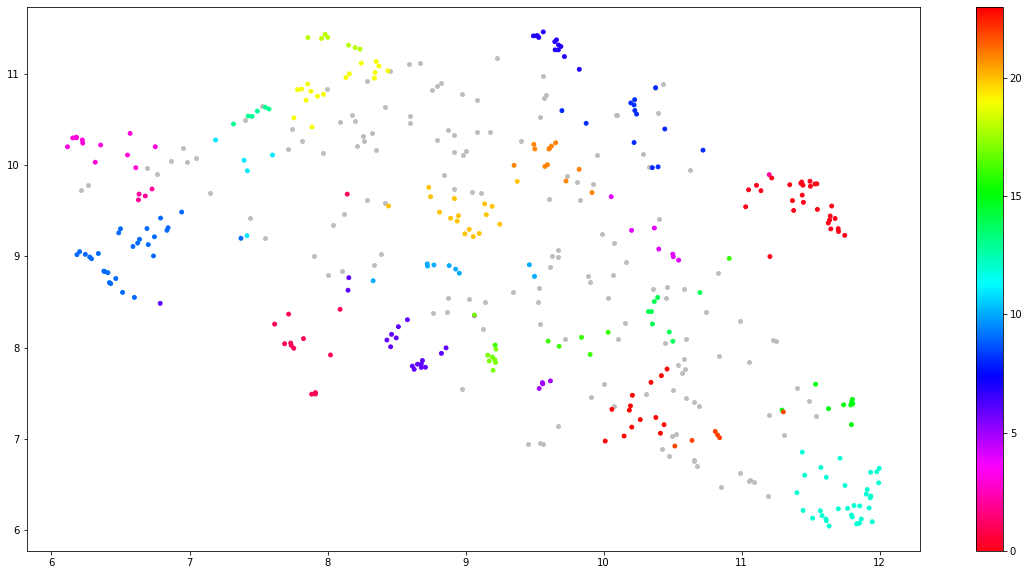

In [ ]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=20, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=15, cmap='hsv_r')
plt.colorbar()

### Top2Vec

Quelle: https://github.com/bhattbhavesh91/Top2Vec-Demo/blob/main/Top2Vec-Notebook.ipynb

In [ ]:
!pip install -q numpy
!pip install -q pandas
!pip install -q gensim
!pip install -q pynndescent>=0.4
!pip install -q umap-learn
!pip install -q hdbscan
!pip install -q wordcloud
!pip install -q tensorflow
!pip install -q tensorflow_hub
!pip install -q tensorflow_text
!pip install -q torch
!pip install -q sentence_transformers
!pip install -q hnswlib
!pip install -q joblib<1.0.0
!pip install -q top2vec[sentence_transformers]

     |████████████████████████████████| 14.8MB 216kB/s 
ERROR: transformers 3.5.1 has requirement sentencepiece==0.1.91, but you'll have sentencepiece 0.1.96 which is incompatible.
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 1.7.0 which is incompatible.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.7.0 which is incompatible.
ERROR: sentence-transformers 2.0.0 has requirement transformers<5.0.0,>=4.6.0, but you'll have transformers 3.5.1 which is incompatible.
ERROR: flair 0.7 has requirement sentencepiece<=0.1.91, but you'll have sentencepiece 0.1.96 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: bertopic 0.8.1 has requirement numpy>=1.20.0, but you'll have numpy 1.19.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |█████████

In [ ]:
import numpy as np
import pandas as pd
from copy import deepcopy
from top2vec import Top2Vec

In [ ]:
docs = list(df.loc[:, "Content"].values)
docs[:5]

['olateltar-li-lat(e (=Wien Klin Wochenschr (2009) 121: 339-343DOI 10.1007/s00508-009-1168-9Printed in Austria© Springer-Verlag 2009 Wiener klinische WochenschriftThe Middle European Journal of Medicine C5a-induced in vitro basophil activation in patients withchronic urticaria: a pilot studyPeter Korosec, Tjasa Subic, Katja Adamic, Mira Silar, Mitja KosnikUniversity Clinic of Respiratory and Allergic Diseases, Golnik, SloveniaSummary. Background: Complement component 5a(C5a) might be involved in the formation of wheals inpatients with chronic urticaria (CU). We sought to compare the in vitro responsiveness of basophils to C5a inpatients with CU and in a control group.Methods: Basophil surface expression of activationmarker CD63 induced by CSa, anti-FceRI mAb or antiIgE pAb was measured using flow cytometry in 17 patients with CU and in 10 healthy controls.Results: Patients with CU showed significantlygreater basophil CD63 surface expression induced byC5a (median [interquartile range]; 

In [ ]:
model = Top2Vec(docs, embedding_model='universal-sentence-encoder')

2021-07-11 09:38:17,822 - top2vec - INFO - Pre-processing documents for training
2021-07-11 09:38:23,763 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
2021-07-11 09:38:39,991 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-07-11 09:38:50,800 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSIO

In [ ]:
model.get_num_topics()

1

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(1)

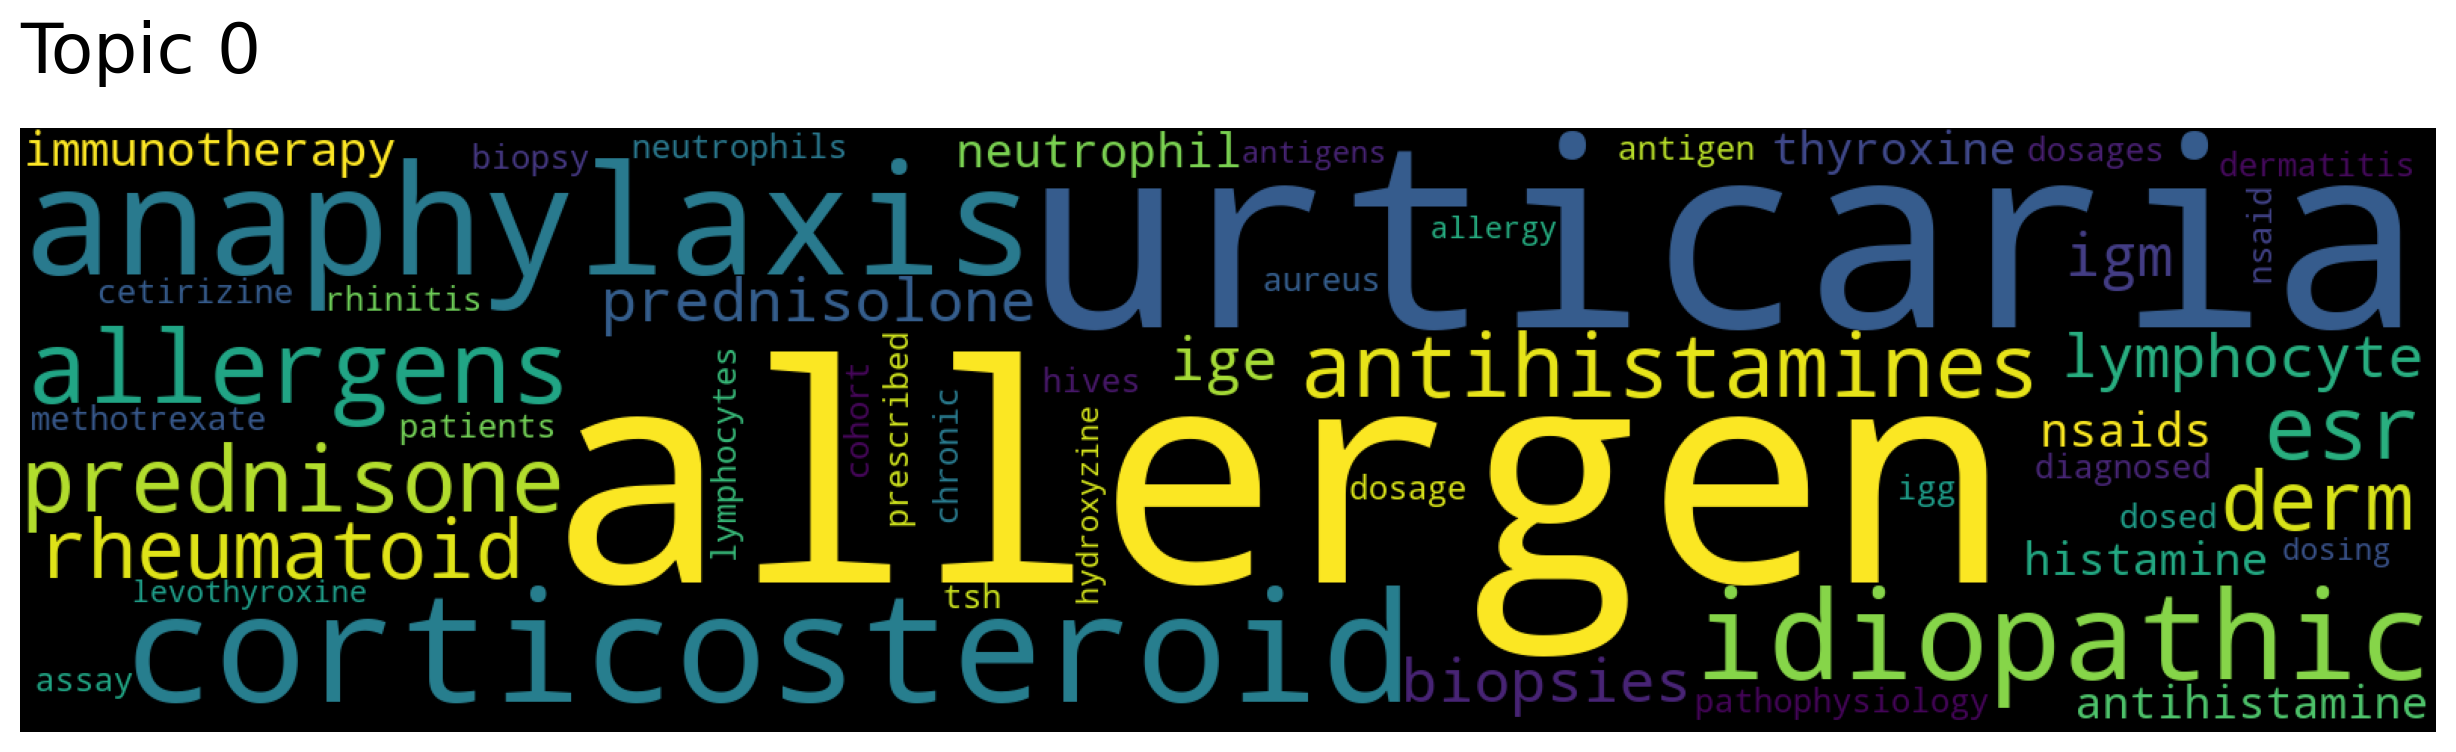

In [ ]:
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

### TFIDF Vertorizer

In [ ]:
tfidfconvert = TfidfVectorizer(ngram_range=(1,1)).fit(df.Corpus.values)

In [ ]:
len(tfidfconvert.vocabulary_)

96412

In [ ]:
words_transformed = tfidfconvert.transform(df.Corpus.values)

### K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans

K-Means für mehrere k's berechnen

In [ ]:
Sum_of_squared_distances = []
max_range = 10
K = range(1,max_range + 1)
for k in K: 
    print(str(k) + "/" + str(max_range))
    km = KMeans(n_clusters=k)
    km = km.fit(words_transformed)
    Sum_of_squared_distances.append(km.inertia_)
    

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


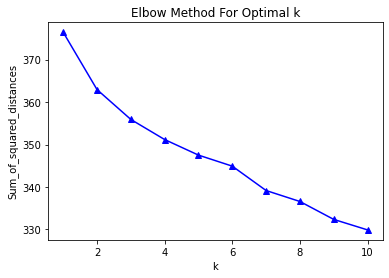

In [ ]:
plt.plot(K,Sum_of_squared_distances, 'b^-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()



# **IDEEN zum Cluster bilden**


- Bag of Words kreiren um neuer Cluster / Wortgruppen zu finden über Häufigkeit der Wörter oder nähe der Wörter zu einander
- Visualisieren des Links zwischen Markern in einer HeatMap
- BioBert einsetzen
- Part of Speech recognition um Autorennamen zu identifizieren 
- AutorenNamen und Marker verknüpfen / clustern
- 


**Generelle Todo's**
- Distinct Values für Abkürzungsverzeichnis erheben und mit Markern abgleichen
- CRISP-DM als Vorgehensmoddel zugrundeliegen
- Begründen Stemm / Lemmatizing - Erörterung im Paper

# === AB HIER IRRELEVANT ===

# 1: A comprehensive overview of the markers / features

Hier vorerst Marker und Features aus der Folie. Mehr kann durch Analyse der Texte oder dem Erstellen eines Dictionaries herausgefunden werden.

In [ ]:
markers = ["Eosinopenia", "Basopenia", "IgT-anti-TPO", "CRP", "IgE"]
features = ["Activity", "Duration", "Comorbid autoimmune diseases", "Angioedema"]

def find_markers(text):
  found_markers = []
  for marker in markers:
    if marker.upper() in text.upper():
      found_markers.append(marker)
  return found_markers

def find_features(text):
  found_features = []
  for feature in features:
    if feature.upper() in text.upper():
      found_features.append(feature)
  return found_features

df['Markers'] = df['Corpus'].apply(find_markers)
df['Features'] = df['Corpus'].apply(find_features)
df

,Authors,Year,Tags,Content,Corpus,Markers,Features
0,Korosec,2009,"Basophil, Allergic Diseases, BAT, Anti-IgE",olateltar-li-lat(e (=Wien Klin Wochenschr (200...,olateltar-li-lat =wien klin wochenschr austria...,"[Basopenia, IgE]",[Angioedema]
1,Asero,2019,"D-Dimer, Duration, Total IgE, CRP, Severity",ORIGINAL ARTICLEEur ANN ALLERGY CLIN IMMUNOL V...,origin articleeur ann allergi clin immunol vol...,"[CRP, IgE]",[]
2,Asero,2020,"D-Dimer, Duration, Omalizumab, Severity",ARE CURRENTLY AVAILABLE BIOMARKERS USEFUL TO D...,are current avail biomark use discrimin csu pa...,"[Basopenia, CRP, IgE]","[Activity, Angioedema]"
3,Gentinetta,2011,"ASST, BAT, Antihistamine",Atopic dermatitis and skin diseaseIndividual I...,atop dermat skin diseaseindividu prime crucial...,[IgE],[Angioedema]
4,Deza,2017,"Severity, Omalizumab, Duration, Basophil, Alle...",Acta Dermato-VenereologicaBBFE(=)2oqo>9d3aI8A}...,acta dermato-venereologicabbf report| check up...,"[Basopenia, IgE]","[Activity, Angioedema]"
...,...,...,...,...,...,...,...
449,Wardhana,2012,"anti-FcεRI, Antihistamine",SPECIAL ARTICLE Chronic Autoimmune UrticariaW...,special articl chronic autoimmun urticariaward...,[IgE],"[Activity, Angioedema]"
450,Kocatürk,2017,"Antihistamine, Omalizumab",Journal of Dermatological Science 87 (2017) 60...,journal dermatolog scienc naselsevi journal de...,[],[Angioedema]
451,Atwa,2014,"ASST, serverity",DOI: 10.1114 1/dv.12124ORIGINAL ARTICLESerum c...,doi articleserum concentr tnf- amongpati chron...,[IgE],[]
452,Kocatürk,2019,"Severity, Duration",World Allergy Organization Journal 12 (2019) 1...,world allergi organ journal content list avail...,[],"[Activity, Angioedema]"


# 2: To understand how the markers/features of Type IIb aiCSU are linked


## How strong is the link between any two given markers? ​

Erste Definition Julian:
 $$link=\frac{AB}{\frac{A+B}{2}}$$


In [ ]:
def str_contains(text, a, b):
  if a in text:
    if b in text:
      return True
  return False

def get_link(a, b):
  if a == b:
    return 1
  # count_a = df[df.Markers.str.join(',').str.contains(a)].Markers.count()
  # count_b = df[df.Markers.str.join(',').str.contains(b)].Markers.count()
  # count_ab = df[df.Markers.str.join(',').str.contains(b)].Markers.count()
  count_a = df[df.Markers.apply(str_contains, a=a, b=a)].Markers.count()
  count_b = df[df.Markers.apply(str_contains, a=b, b=b)].Markers.count()
  count_ab = df[df.Markers.apply(str_contains, a=a, b=b)].Markers.count()
  return (count_ab/(0.5*(count_a+count_b)))


link = get_link(markers[0], markers[1])
link
# df_x = df[df['Markers'].isin(['IgE'])]
# df_x
# df_x = df[all(x in  for x in [])]['Markers'].count()
# df_x = df.Markers.to_list()
# all(x in ['b', 'a', 'foo', 'bar'] for x in ['a', 'b'])

# all(x in ['b', 'a', 'foo', 'bar'] for x in ['a', 'b'])
# df_x


# df[str_contains(df.Markers.str.join(','), , )]

# df['Markers'].apply(str_contains, a = 'CRP', b='IgE')

0.25925925925925924

In [ ]:
# df_markers = pd.DataFrame()
# for marker_a in markers:
#   df_markers[marker_a] = []
#   #marker_links = []
#   for marker_b in markers:
#     df_markers = df_markers[marker_a].append(pd.Series(get_link(marker_a, marker_b)))
#   #df_markers.append(marker_links)
# df_markers

# mylist = []
# for marker in markers:
#   mylist.append(markers)

# mylist

# df_markers = pd.DataFrame(markers, columns=markers)
# df_markers


df_markers = pd.DataFrame(index=markers, columns=markers)
df_markers

for marker_a in markers:
  for marker_b in markers:
    df_markers[marker_a][marker_b] = get_link(marker_a, marker_b)

df_markers

,Eosinopenia,Basopenia,IgT-anti-TPO,CRP,IgE
Eosinopenia,1,0.259259,0,0.0555556,0.039801
Basopenia,0.259259,1,0,0.219178,0.209091
IgT-anti-TPO,0,0,1,0,0
CRP,0.0555556,0.219178,0,1,0.34413
IgE,0.039801,0.209091,0,0.34413,1


## Did the publication show a difference for marker a in patients stratified by marker b (and vice versa) and how big was the difference? ​

## Did the publication show a correlation between a and b and how strong was it? ​

## Was the result of a study that showed a link between a and b reproducible? ​


## How many studies confirmed the link? 

## How many studies failed to reproduce the link? ​

## How good is the quality of the study that demonstrates a link (how many patients?, how well characterized?, multicenter?, prospective vs retrospective, etc….)?